In [1]:
import random
import math
import os
import pickle
from tqdm import tqdm, trange
import numpy as np

import sklearn
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pdb

In [2]:
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [3]:
from pytorch_pretrained_bert import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [6]:
data_pkl_path = "../../data/hotpot_doc_level/"
data_pkl_name = "preprocessed_dev.pkl"
predictions_pkl_path = "./"
predictions_pkl_name = "predictions.pkl"

In [7]:
def score(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    assert(len(gt) != 0)
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_correct = 0
    for i in range(total_size):
        if(gt[i] == pred[i]):
            total_correct += 1
        p = precision_score(gt[i], pred[i],average="binary")
        r = recall_score(gt[i], pred[i],average="binary")
        total_precision += p
        total_recall += r
        total_f1 += 2*(p*r)/(p+r) if (p+r)>0 else 0
    return {"precision":total_precision/total_size, "recall":total_recall/total_size, 
            "f1":total_f1/total_size, "em":total_correct/total_size}

In [8]:
dataset = unpickler(data_pkl_path, data_pkl_name)

In [9]:
dataset.keys()

dict_keys(['sequence', 'sentence_start_index', 'sentence_end_index', 'supporting_fact', 'segment_id', 'max_seq_len', 'max_sentences', 'document_length'])

In [10]:
predictions_raw = unpickler(predictions_pkl_path, predictions_pkl_name)

In [11]:
dataset['document_length'][4]

[4, 2, 3, 2, 4, 22, 3, 4, 5, 3]

In [28]:
predictions_raw.shape

(73690, 10)

In [29]:
predictions_raw[:5]

array([[ -9.092889 , -11.627383 , -11.362666 , -12.481646 , -12.481646 ,
        -12.481646 , -12.481646 , -12.481646 , -12.481646 , -12.481646 ],
       [  6.6942716,  -4.354312 ,  -6.243289 , -12.298203 , -12.298203 ,
        -12.298203 , -12.298203 , -12.298203 , -12.298203 , -12.298203 ],
       [-12.386548 , -12.617335 , -12.974067 , -12.584182 , -12.845939 ,
        -12.472897 , -12.472897 , -12.472897 , -12.472897 , -12.472897 ],
       [-11.8994465, -12.534382 , -12.188662 , -12.438282 , -12.815713 ,
        -12.492678 , -12.492678 , -12.492678 , -12.492678 , -12.492678 ],
       [  7.1253586, -12.241236 , -12.241236 , -12.241236 , -12.241236 ,
        -12.241236 , -12.241236 , -12.241236 , -12.241236 , -12.241236 ]],
      dtype=float32)

In [13]:
def reorganize_predictions(predictions, document_lengths):
    out_list = []
    start_index = 0
    for i in range(len(document_lengths)):
        pred_raw = predictions[start_index:start_index+len(document_lengths[i])]
        pred = []
        for j,p in enumerate(pred_raw):
            pred += p[:document_lengths[i][j]]
            pred += [0] * (document_lengths[i][j] - len(p[:document_lengths[i][j]]))
        out_list.append(pred)
        start_index += len(document_lengths[i])
    return out_list

In [14]:
predictions_reorganized = reorganize_predictions(predictions_raw.tolist(), dataset['document_length'])

In [15]:
supporting_facts_reorganized = reorganize_predictions(dataset['supporting_fact'], dataset['document_length'])

In [16]:
for i in trange(len(predictions_reorganized)):
    assert(len(supporting_facts_reorganized[i]) == len(predictions_reorganized[i]))

100%|██████████| 7404/7404 [00:00<00:00, 467986.18it/s]


In [17]:
for i in trange(len(predictions_reorganized)):
    assert(sum(dataset['document_length'][i]) == len(predictions_reorganized[i]))

100%|██████████| 7404/7404 [00:00<00:00, 755403.23it/s]


In [18]:
def evaluate(gt, pred, threshold, document_lengths):
    pred_answer_labels = (torch.sigmoid(torch.tensor(pred)) > threshold).numpy().tolist()
    predictions_reorganized = reorganize_predictions(pred_answer_labels, document_lengths)
    supporting_facts_reorganized = reorganize_predictions(gt, document_lengths)
    result = score(supporting_facts_reorganized, predictions_reorganized)
    return result

In [27]:
evaluate(dataset['supporting_fact'], predictions_raw, 0.5, dataset['document_length'])

{'precision': 0.849452623206682,
 'recall': 0.7934483612461776,
 'f1': 0.7948369379285303,
 'em': 0.45029713668287413}

In [20]:
metrics = {'precision':[], 'recall':[], 'f1':[], 'em':[]}
for t in tqdm(np.linspace(0.1,1,18,endpoint=False)):
    result = evaluate(dataset['supporting_fact'], predictions_raw, t, dataset['document_length'])
    for key,value in result.items():
        metrics[key].append(value)

100%|██████████| 18/18 [03:53<00:00, 12.79s/it]


In [21]:
max(metrics['f1'])

0.8019736603813006

In [22]:
max(metrics['em'])

0.45475418692598596

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
metric_df = pd.DataFrame(metrics, index=np.linspace(0.1,1,18,endpoint=False))

In [25]:
metric_df

,precision,recall,f1,em
0.10,0.737553,0.903307,0.783655,0.334819
0.15,0.765488,0.883964,0.792486,0.367909
0.20,0.786192,0.868167,0.797709,0.394922
0.25,0.802483,0.854377,0.800600,0.411264
0.30,0.816624,0.840774,0.801974,0.426256
0.35,0.827062,0.828255,0.801504,0.437871
0.40,0.835533,0.816022,0.799874,0.443544
0.45,0.842484,0.804109,0.797198,0.445570
0.50,0.849453,0.793448,0.794837,0.450297
0.55,0.856984,0.781227,0.791645,0.454754


<Figure size 432x288 with 0 Axes>

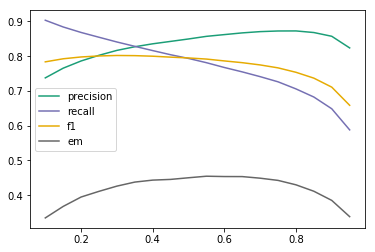

In [26]:
plt.figure(); metric_df.plot(colormap="Dark2");

In [30]:
import seaborn as sns

/home/bhargav/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


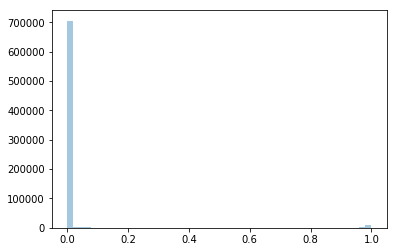

In [36]:
sns.distplot((torch.sigmoid(torch.tensor(predictions_raw))).numpy().flatten(),kde=False, hist=True, rug=False)